In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Leer el archivo CSV
df = pd.read_csv('Financials.csv')

In [4]:
# Eliminar espacios en blanco de los nombres de las columnas
df.columns = df.columns.str.strip()

In [5]:
# Renombrar las columnas
df = df.rename(columns={
    'Segment': 'segment', 
    'Country': 'country', 
    'Product': 'product', 
    'Discount Band': 'discount_band', 
    'Units Sold': 'units_sold',
    'Manufacturing Price': 'manufacturing_price', 
    'Sale Price': 'sale_price', 
    'Gross Sales': 'gross_sales', 
    'Discounts': 'discounts',
    'Sales': 'sales', 
    'COGS': 'cogs', 
    'Profit': 'profit', 
    'Date': 'date', 
    'Month Number': 'month_number', 
    'Month Name': 'month_name',
    'Year': 'year'
})

In [6]:
# Convertir la columna 'date' a tipo datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

In [7]:
# Convertir las columnas categóricas a numéricas
label_encoder = preprocessing.LabelEncoder()
categorical_columns = ['segment', 'country', 'product', 'discount_band']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [8]:
# Limpiar y convertir columnas numéricas
numeric_columns = ['units_sold', 'manufacturing_price', 'sale_price', 'discounts', 'profit']
for column in numeric_columns:
    df[column] = df[column].replace({'\$': '', ',': '', '\(': '', '\)': '', '-': '0', ' ': ''}, regex=True)
    df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(float)

In [9]:
# Guardar los valores originales de units_sold
units_sold_original = df['units_sold'].copy()

In [10]:
# Normalizar las columnas numéricas, excluyendo 'units_sold' para evitar el problema
scaler = MinMaxScaler()
numeric_columns_to_normalize = ['manufacturing_price', 'sale_price', 'discounts', 'profit', 'month_number']
df[numeric_columns_to_normalize] = scaler.fit_transform(df[numeric_columns_to_normalize])

In [11]:
# Eliminar columnas no necesarias
df = df.drop(columns=['month_name', 'year', 'cogs', 'gross_sales'])

In [12]:
# Dividir datos en variables independientes y dependientes
y = df['units_sold']
x = df.drop(['units_sold', 'sales', 'date'], axis=1)  # Excluir 'date' de las variables independientes

# Dividir en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Crear y entrenar el modelo Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(x_train, y_train)

GradientBoostingRegressor(random_state=42)

In [14]:
# Generar fechas futuras para los próximos 3 meses
future_dates = pd.date_range(start=df['date'].max(), periods=3, freq='MS')

In [15]:
# Crear un DataFrame para las predicciones futuras
future_data = []
for date in future_dates:
    for segment in df['segment'].unique():
        for country in df['country'].unique():
            for product in df['product'].unique():
                future_data.append([segment, country, product, df['discount_band'].mean(), 
                                    df['manufacturing_price'].mean(), df['sale_price'].mean(), 
                                    df['discounts'].mean(), df['profit'].mean(), df['month_number'].mean()])

future_df = pd.DataFrame(future_data, columns=['segment', 'country', 'product', 'discount_band', 
                                               'manufacturing_price', 'sale_price', 'discounts', 
                                               'profit', 'month_number'])

In [16]:
# Normalizar las columnas numéricas del DataFrame futuro
future_df[numeric_columns_to_normalize] = scaler.transform(future_df[numeric_columns_to_normalize])

In [17]:
# Realizar predicciones para los próximos 3 meses
future_predictions_normalized = gb_model.predict(future_df)  # Utilizar todas las columnas para las predicciones

In [18]:
# Revertir la normalización de las predicciones
scaler_units_sold = MinMaxScaler()
units_sold_original = units_sold_original.values.reshape(-1, 1)
scaler_units_sold.fit(units_sold_original)
future_predictions_original = scaler_units_sold.inverse_transform(future_predictions_normalized.reshape(-1, 1))

In [19]:
# Agregar las predicciones al DataFrame futuro
future_df['predicted_units_sold'] = future_predictions_original

In [20]:
# Mantener las columnas originales antes de la codificación OneHotEncoder
future_df_original = future_df[['segment', 'country', 'product']].copy()

In [21]:
# Crear un codificador OneHotEncoder para manejar las etiquetas desconocidas
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

In [22]:
# Codificar las variables categóricas en el DataFrame futuro
future_encoded = future_df[categorical_columns]
future_encoded = onehot_encoder.fit_transform(future_encoded).toarray()

In [23]:
# Obtener los nombres de las columnas después de la codificación
feature_names = onehot_encoder.get_feature_names_out(categorical_columns)

In [24]:
# Crear un nuevo DataFrame con las variables categóricas codificadas
future_encoded_df = pd.DataFrame(future_encoded, columns=feature_names)

In [26]:
# Combinar el DataFrame codificado con el DataFrame original
future_df = pd.concat([future_df.drop(categorical_columns, axis=1), future_encoded_df], axis=1)

# Agregar las columnas originales al DataFrame futuro
future_df = pd.concat([future_df, future_df_original], axis=1)

# Agregar de nuevo la columna de fechas
future_df['date'] = np.repeat(future_dates, len(future_df) // len(future_dates))

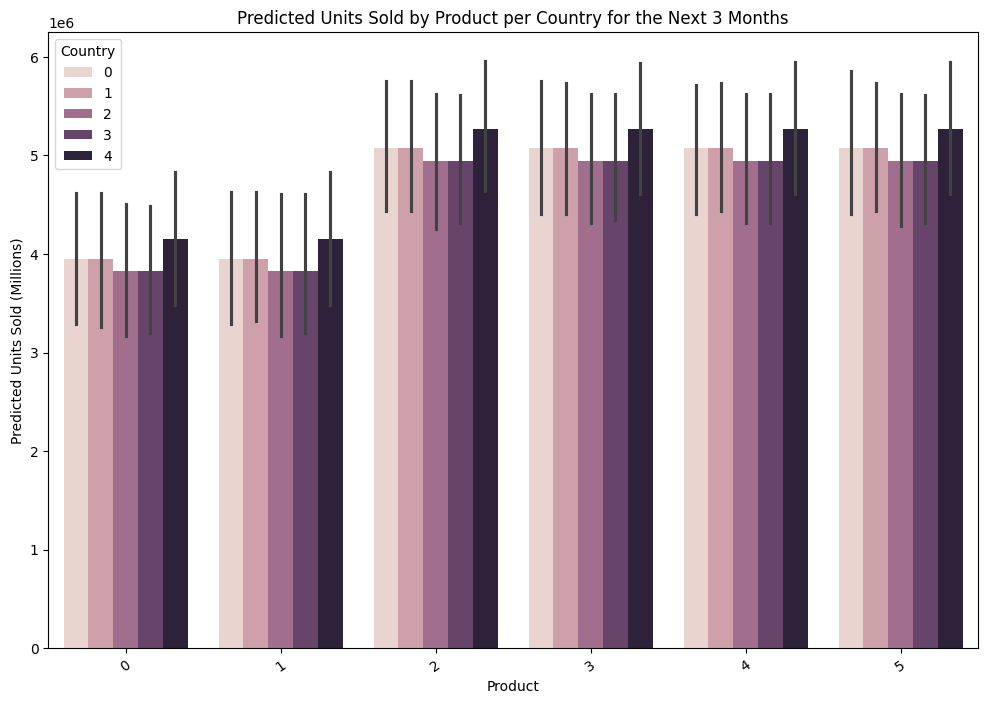

In [28]:
# Verificar la presencia de las columnas 'product', 'country' y 'segment' en future_df
if all(col in future_df.columns for col in ['product', 'country', 'segment']):
    # Realizar la agrupación y cálculo de la suma de 'predicted_units_sold'
    grouped_predictions = future_df.groupby(['product', 'country', 'segment'])['predicted_units_sold'].sum().reset_index()
    # Visualizar las predicciones
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_predictions, x='product', y='predicted_units_sold', hue='country')
    plt.title('Predicted Units Sold by Product per Country for the Next 3 Months')
    plt.xlabel('Product')
    plt.ylabel('Predicted Units Sold (Millions)')
    plt.legend(title='Country')
    plt.xticks(rotation = 35);
    plt.show()
else:
    print("Las columnas 'product', 'country' y 'segment' no están presentes en el DataFrame future_df.")

In [29]:
# Validar el modelo
y_pred = gb_model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False returns RMSE
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print('R^2 Score:', r2)

Mean Absolute Error (MAE): 199.62632186827136
Root Mean Squared Error (RMSE): 288.7178683643029
R^2 Score: 0.8761442378706819


c:\Users\MiPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
